# 权重衰退

In [1]:
# Import package

import torch
from torch import nn
from torch.utils import data
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline


## 生成一个人工数据集

$$
y=0.05+\sum^d_{i=1}0.01x_i+\epsilon,\text{ where }\epsilon \sim \mathcal{N}(0, 0.01)
$$

In [2]:
def generate_data(w, b, num_size):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_size, len(w)))
    y = torch.matmul(X, w) + b
    epsilon = torch.normal(0, 0.01, y.shape)
    y += epsilon
    return X, torch.reshape(y, (-1, 1))


def load_array(data_arrays, batch_size, shuffle=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=shuffle)


n_train, n_test, num_inputs = 20, 100, 200
batch_size = 5
true_w, true_b = torch.ones((num_inputs, 1)), 0.05
train_data, test_data = generate_data(
    true_w, true_b, n_train), generate_data(true_w, true_b, n_test)
train_iter, test_iter = load_array(train_data, batch_size), load_array(
    test_data, batch_size, shuffle=False)


## 定义训练实现

In [3]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


class Animator:
    """在动画中绘制数据。"""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def evaluate_loss(net, data_iter, loss):
    metric = Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]


In [4]:
def train(wd):
    net = nn.Sequential(
        nn.Linear(num_inputs, 1)
    )
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epoch, lr = 100, 0.003
    trainer = torch.optim.SGD([{
        "params": net[0].weight,
        "weight_decay": wd
    }, {
        "params": net[0].bias
    }], lr=lr)

    animator = Animator(
        xlabel='epochs',
        xlim=[5, num_epoch],
        ylabel='loss',
        yscale='log',
        legend=['train', 'test']
    )

    for epoch in range(num_epoch):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(
                epoch + 1,
                (evaluate_loss(net, train_iter, loss),
                 evaluate_loss(net, test_iter, loss))
            )
    print("L2:", net[0].weight.norm().item())


## 开始训练

L2: 14.769489288330078


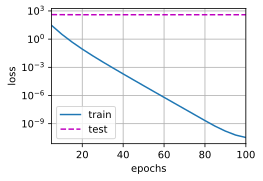

In [5]:
train(0)

L2: 4.169295787811279


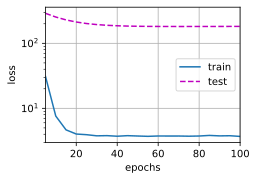

In [6]:
train(3)